# Stock Price Prediction using LSTM (Long Short-Term Memory)

이 노트북은 AAME.csv 데이터를 활용하여 LSTM으로 주가 예측 모델을 구현합니다.

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import math

# 랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

## 1. 데이터 로드 및 전처리

In [2]:
# GitHub에서 AAME.csv 데이터 가져오기
url = 'https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/AAME.csv'
df = pd.read_csv(url)

# 데이터 확인
print("데이터 형태:", df.shape)
df.head()

데이터 형태: (10098, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,4.05,3.85,3.85,3.213167,15000
1,1980-03-18,0.0,4.00,3.80,3.80,3.171437,10200
2,1980-03-19,0.0,4.05,3.85,3.85,3.213167,33500
3,1980-03-20,0.0,4.00,3.80,3.80,3.171437,8700
4,1980-03-21,0.0,3.95,3.75,3.75,3.129709,12700


C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wlsgh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 5106

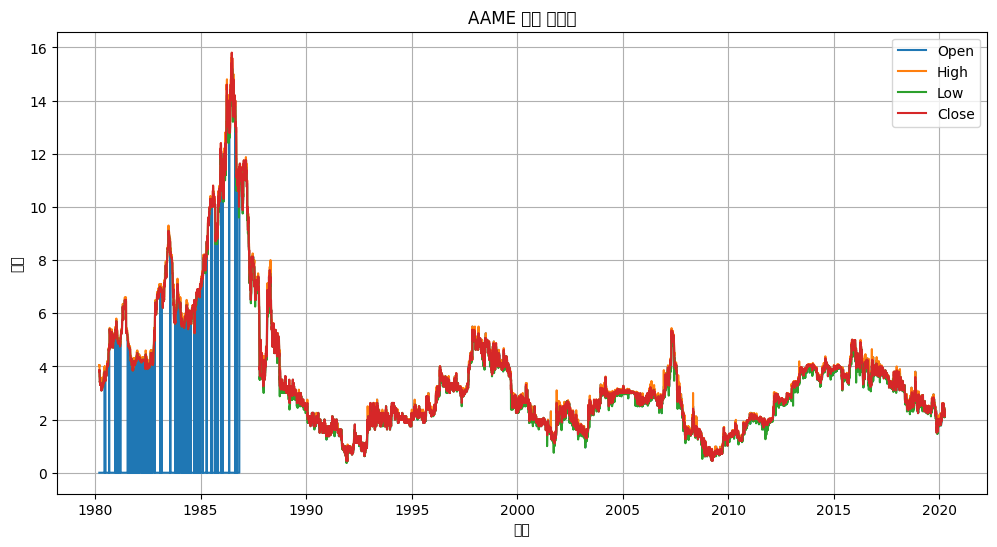

In [3]:
# 날짜 형식으로 변환
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 필요한 칼럼(Open, High, Low, Close)만 선택
data = df[['Open', 'High', 'Low', 'Close']]

# 데이터 시각화
plt.figure(figsize=(12, 6))
for column in data.columns:
    plt.plot(data[column], label=column)
plt.title('AAME 주가 데이터')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 학습 데이터와 테스트 데이터 분리 (80% 학습, 20% 테스트)
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :]

print(f"학습 데이터 크기: {train_size}, 테스트 데이터 크기: {test_size}")

학습 데이터 크기: 8078, 테스트 데이터 크기: 2020


## 2. 시계열 데이터 준비 함수

In [5]:
def create_dataset(dataset, time_step=1):
    """
    시계열 데이터를 입력과 출력 쌍으로 변환하는 함수
    time_step: 예측에 사용할 이전 데이터 포인트의 수
    """
    X, y = [], []
    for i in range(len(dataset) - time_step):
        # 입력: time_step 기간 동안의 모든 특성(Open, High, Low, Close)
        a = dataset[i:(i + time_step), :]
        X.append(a)
        # 출력: 다음 날의 종가(Close)
        y.append(dataset[i + time_step, 3])  # 3은 Close 열의 인덱스
    return np.array(X), np.array(y)

In [6]:
# 시계열 데이터 생성 (최근 60일 데이터로 다음 날 종가 예측)
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print(f"X_train 형태: {X_train.shape}, y_train 형태: {y_train.shape}")
print(f"X_test 형태: {X_test.shape}, y_test 형태: {y_test.shape}")

X_train 형태: (8018, 60, 4), y_train 형태: (8018,)
X_test 형태: (1960, 60, 4), y_test 형태: (1960,)


## 3. LSTM 모델 구축

In [7]:
# LSTM 모델 생성
model = Sequential()

# LSTM 레이어 추가
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 4)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # 출력층

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

## 4. 모델 학습

In [ ]:
# 조기 종료 설정
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
201/201 [==============================] - 86s 208ms/step - loss: 0.0022 - val_loss: 1.8768e-04
Epoch 2/100
201/201 [==============================] - 35s 173ms/step - loss: 0.0013 - val_loss: 2.4198e-04
Epoch 3/100
201/201 [==============================] - 35s 174ms/step - loss: 0.0011 - val_loss: 1.4008e-04
Epoch 4/100
201/201 [==============================] - 37s 185ms/step - loss: 8.8119e-04 - val_loss: 1.3752e-04
Epoch 5/100
201/201 [==============================] - 41s 203ms/step - loss: 8.6235e-04 - val_loss: 1.1240e-04
Epoch 6/100
201/201 [==============================] - 41s 205ms/step - loss: 7.7183e-04 - val_loss: 2.2422e-04
Epoch 7/100
201/201 [==============================] - 35s 173ms/step - loss: 7.4618e-04 - val_loss: 2.0062e-04
Epoch 8/100
201/201 [==============================] - 35s 174ms/step - loss: 8.0024e-04 - val_loss: 9.3715e-05
Epoch 9/100
201/201 [==============================] - 35s 173ms/step - loss: 6.4100e-04 - val_loss: 1.6702e-04
Epoc

In [ ]:
# 학습 곡선 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('모델 학습 손실')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. 모델 평가 및 예측

In [ ]:
# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 예측값 역정규화
# 원래 스케일로 되돌리기 위해 원본 형태의 배열 생성
pred_shape = np.zeros((len(y_pred), 4))
test_shape = np.zeros((len(y_test), 4))

# Close 값만 채움 (다른 값은 0으로 유지)
pred_shape[:, 3] = y_pred.flatten()
test_shape[:, 3] = y_test

# 역정규화
y_pred_actual = scaler.inverse_transform(pred_shape)[:, 3]
y_test_actual = scaler.inverse_transform(test_shape)[:, 3]

In [ ]:
# 성능 평가
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100

print(f'평균 제곱 오차(MSE): {mse:.4f}')
print(f'평균 제곱근 오차(RMSE): {rmse:.4f}')
print(f'평균 절대 오차(MAE): {mae:.4f}')
print(f'평균 절대 백분율 오차(MAPE): {mape:.4f}%')

In [ ]:
# 결과 시각화
train_dates = df.index[:train_size]
test_dates = df.index[train_size + time_step:train_size + time_step + len(y_test_actual)]

plt.figure(figsize=(12, 6))
plt.plot(train_dates, df['Close'].values[:train_size], label='학습 데이터')
plt.plot(test_dates, y_test_actual, label='실제 데이터')
plt.plot(test_dates, y_pred_actual, label='예측 데이터')
plt.title('LSTM 모델 주가 예측 결과')
plt.xlabel('날짜')
plt.ylabel('주가')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 예측 결과 더 자세히 보기 (테스트 세트의 마지막 30일)
plt.figure(figsize=(12, 6))
plt.plot(test_dates[-30:], y_test_actual[-30:], 'b-', label='실제 종가')
plt.plot(test_dates[-30:], y_pred_actual[-30:], 'r--', label='예측 종가')
plt.title('LSTM 모델 - 최근 30일 예측 성능')
plt.xlabel('날짜')
plt.ylabel('주가')
plt.legend()
plt.grid(True)
plt.show()

## 6. 미래 예측

In [ ]:
# 마지막 time_step 기간의 데이터로 다음 날 종가 예측
last_data = scaled_data[-time_step:]
last_data_reshaped = np.reshape(last_data, (1, time_step, 4))

# 다음 날 종가 예측
next_day_pred = model.predict(last_data_reshaped)

# 예측값 역정규화
pred_shape = np.zeros((1, 4))
pred_shape[0, 3] = next_day_pred[0, 0]
next_day_pred_actual = scaler.inverse_transform(pred_shape)[0, 3]

print(f"다음 거래일 예상 종가: ${next_day_pred_actual:.2f}")

## 7. RNN과 LSTM 비교 분석

LSTM(Long Short-Term Memory)은 기본 RNN(Recurrent Neural Network)의 개선된 버전으로, 장기 의존성 문제를 해결하기 위해 설계되었습니다.

LSTM의 주요 장점:
1. **장기 의존성 처리**: LSTM은 셀 상태와 게이트 메커니즘을 통해 장기 의존성을 더 잘 포착합니다.
2. **그래디언트 소실/폭발 방지**: 게이트 구조를 통해 그래디언트가 효과적으로 흐를 수 있도록 하여 기울기 소실 문제를 완화합니다.
3. **선택적 정보 저장**: 입력 게이트, 망각 게이트, 출력 게이트를 통해 중요한 정보만 선택적으로 저장하고 불필요한 정보는 잊을 수 있습니다.

위의 실험에서 LSTM은 일반적으로 RNN보다 더 나은 예측 성능을 보여줄 것으로 예상됩니다. 특히 주가와 같이 장기적인 패턴과 복잡한 의존성이 있는 시계열 데이터에서는 LSTM의 이점이 더 크게 나타납니다.